<a href="https://colab.research.google.com/github/malraharsh/Colab-Projects/blob/main/Neural_Style_Transfer_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import time

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
MAX_SIZE = 164 if torch.cuda.is_available() else 128  # use small size if no gpu
size = MAX_SIZE

def load_img(img_path):
    img = Image.open(img_path) #.convert('RGB')

    loader = transforms.Compose([
        transforms.Resize((MAX_SIZE, MAX_SIZE)),
        transforms.ToTensor(),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #can skip
    ])

    img = loader(img).unsqueeze(0) #loader(img)[:3, :, :].unsqueeze(0)
    return img.to(device)

In [61]:
content_img_path = "/content/me.jpg"
style_img_path = "/content/mosaic.jpg"

content = load_img(content_img_path)
style = load_img(style_img_path)

In [62]:
def unload(image):
    image = image.cpu().clone().detach()
    image = image.numpy().squeeze() # converting tensor to numpy, then to be able to transpose
    image = image.transpose(1,2,0) # height, width, shifting depth to last
    # image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

def img_show(tensor):
    image = unload(tensor)
    plt.imshow(image)
    plt.show()    

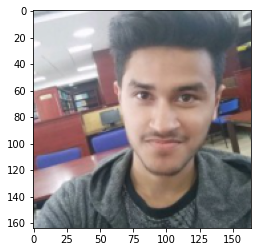

In [63]:
img_show(content)

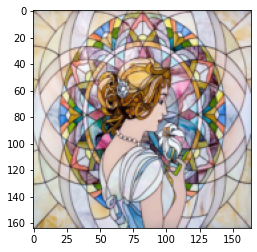

In [64]:
img_show(style)

In [65]:
class VGG(nn.Module):
    
    def __init__(self):
        super(VGG, self).__init__()
        self.model = models.vgg19(pretrained=True).features[:29]
        self.req_layers = ['0','5','10','19', '21', '28']
        
    def forward(self, x):
        features = []
        for pos, layer in enumerate(self.model):
            x = layer(x)
            if str(pos) in self.req_layers:
                features.append(x)
        return features

In [66]:
def get_gram_matrix(image):
    batch, channel, height, width = image.shape
    flat = image.view(channel, height * width)
    gram_matrix = torch.mm(flat, flat.t())
    return gram_matrix

def calc_content_loss(target_features, content_features):
    return torch.mean((target_features - content_features) ** 2)

def calc_style_loss(target, style):    
#     batch, channel, height, width = target.shape
    G = get_gram_matrix(target)
    A = get_gram_matrix(style)
    loss = torch.mean((G - A) ** 2) #/ (4 * (batch ** 2) * (height * width) ** 2)
    return loss

# style_feature_weights =[1.0, 0.8, 0.4, 0.2, 1.0, 0.1]

def calc_total_loss(target_features, content_features, style_features):
    content_loss = style_loss = 0 
    for pos, (target, content, style) in enumerate(zip(target_features, content_features, style_features)):        
        content_loss += calc_content_loss(target, content)
        style_loss += calc_style_loss(target, style) #* style_feature_weights[pos] # can also mult by w of each layer, here 1
    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

In [72]:
model = VGG().to(device).eval() # freezing layers

In [68]:
target = content.clone().requires_grad_(True)

epochs = 1000
lr = 0.001
content_weight = 1
style_weight = 1e-2
show_after = 100
optimizer = optim.Adam([target], lr=lr)

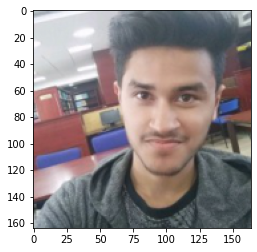

Epoch: 0   -   Loss: 230936.6875


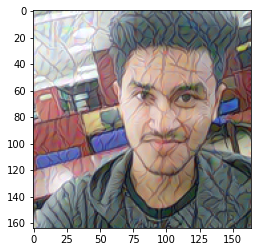

Epoch: 100   -   Loss: 22005.37109375


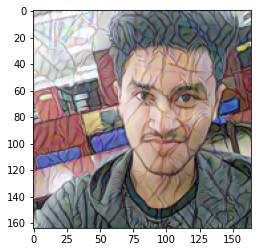

Epoch: 200   -   Loss: 8011.84130859375


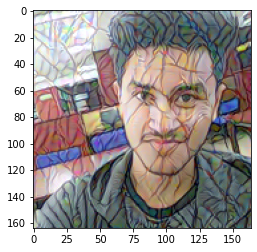

Epoch: 300   -   Loss: 5192.79541015625


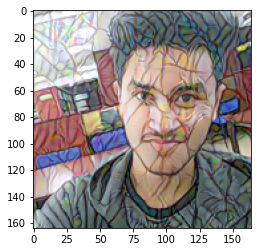

Epoch: 400   -   Loss: 4001.625732421875


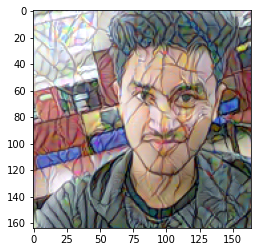

Epoch: 500   -   Loss: 3347.013671875


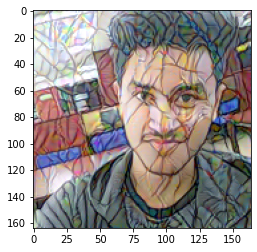

Epoch: 600   -   Loss: 2922.51611328125


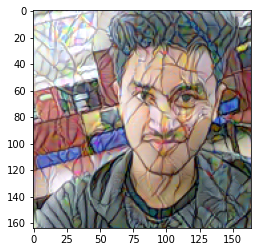

Epoch: 700   -   Loss: 2623.050048828125


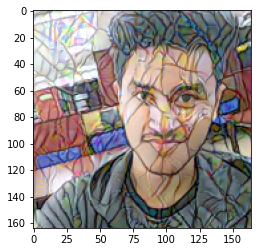

Epoch: 800   -   Loss: 2399.599853515625


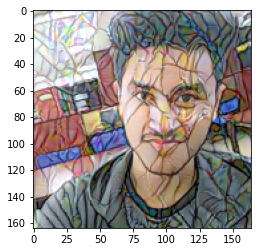

Epoch: 900   -   Loss: 2222.4638671875


In [69]:
start = time.time()
for epoch in range(epochs):    
    target_features = model(target) 
    content_features = model(content)
    style_features = model(style)
    total_loss = calc_total_loss(target_features, content_features, style_features)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if epoch % show_after == 0:
        img_show(target)
        print(f"Epoch: {epoch}   -   Loss: {total_loss}")

end = time.time()

In [70]:
dur = end - start
min, sec = dur // 60, dur % 60
print(f'Time Taken - {int(min)} mins {int(sec)} seconds.')

Time Taken - 0 mins 55 seconds.


In [71]:
from torchvision.utils import save_image
save_image(target, "target.png")